In [4]:
import requests
import time

coin_id = "bitcoin"
url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"

to_ts = int(time.time())                 
from_ts = to_ts - 90 * 24 * 60 * 60    

params = {    
    "vs_currency": "usd",
    "from": from_ts,
    "to": to_ts        
}

response = requests.get(url, params=params)
data = response.json()

print(data)

{'prices': [[1753995911511, 116489.76446076382], [1753999428352, 116391.84691126367], [1754003271296, 116112.82911807846], [1754006915626, 115744.99154744405], [1754010326746, 115457.87296115351], [1754013633103, 115193.26697712376], [1754017713000, 115881.73853569946], [1754021098753, 115593.02471647075], [1754024813254, 115653.79200909757], [1754028215311, 115567.06812831752], [1754031861940, 115137.48194645529], [1754035469730, 114917.38364970933], [1754039081313, 114825.56090684517], [1754042789140, 114922.64775869504], [1754046519138, 114737.39946104163], [1754050141116, 115259.22635047193], [1754053430870, 115722.39346484495], [1754057064948, 114321.83005602808], [1754060948540, 115457.05523496658], [1754064280409, 115341.31045835916], [1754068043337, 115001.68358109772], [1754071465831, 114390.77429028435], [1754075040204, 113789.0617852387], [1754078562438, 113288.23503954308], [1754082249754, 113893.84178893776], [1754086134512, 113899.43163692605], [1754089750655, 113069.9349

In [5]:
import pandas as pd
import numpy as np

def normalize_coingecko_series(data, field="prices", col="BTC"):
    df = pd.DataFrame(data[field], columns=["ts_ms", col])
    df["date"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
    df = df.drop(columns=["ts_ms"]).drop_duplicates(subset=["date"]).sort_values("date")
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].ffill(limit=3)
    return df[["date", col]]
btc_df = normalize_coingecko_series(data, col="BTC")
btc_df.head()

def to_daily_close(df, value_col):
    s = df.set_index("date")[value_col].sort_index()
    daily = s.resample("1D").last().ffill(limit=2)
    return daily.reset_index().rename(columns={value_col: value_col})

btc_daily = to_daily_close(btc_df, "BTC")
btc_daily.head()

,date,BTC
0,2025-07-31 00:00:00+00:00,116112.829118
1,2025-08-01 00:00:00+00:00,113069.934935
2,2025-08-02 00:00:00+00:00,112869.397814
3,2025-08-03 00:00:00+00:00,114319.437991
4,2025-08-04 00:00:00+00:00,115291.215913


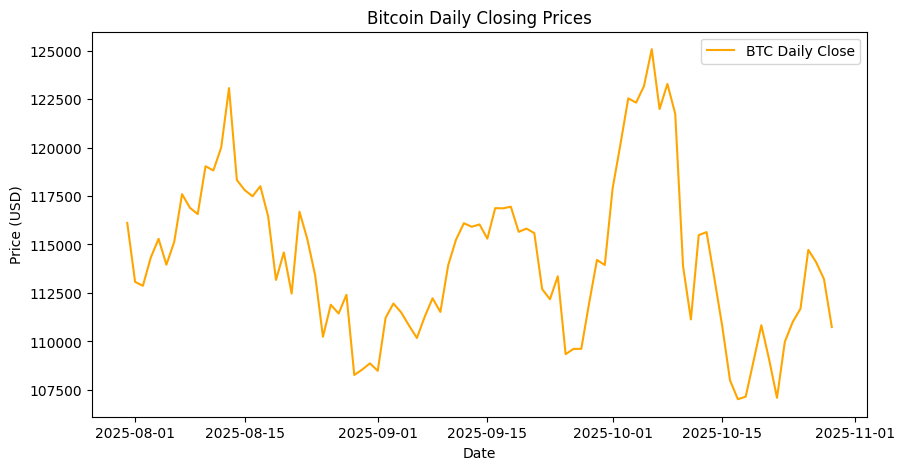

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(btc_daily["date"], btc_daily["BTC"], color="orange", label="BTC Daily Close")
plt.title("Bitcoin Daily Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [12]:
import numpy as np 

# Sharp Ratio Grading Thresholds:
# Less than 1: Bad
# 1 – 1.99: Adequate/good
# 2 – 2.99: Very good
# Greater than 3: Excellent

# prices: array of prices
# rf: risk-free rate of return
def risk_return(prices, rf=0.04):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    risk = np.std(returns)
    reward = np.mean(returns)
    return reward - rf / risk

print(risk_return(btc_daily["BTC"]))

-2.213693680517121
